## EXPERIMENT 1.2: AdaFace

In [1]:
## Load libraries

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white")
%matplotlib inline
sys.path.append('../../utils')
from Model_utils.Model_funcs import *
from Result_metric_utils.result_metrics import *
from Data_proc_utils.Data_proc_funcs import *
from DET_utils.DET_plots import *
from DET_utils.DET import *
from Plotting_stats_utils.plotting_threshold import *
from Plotting_stats_utils.stats_tables import *

from IPython import embed


# Load data

In [2]:
# feature_list_children = '../../data/data_full/feature_vectors/adaface_feature_vectors/similarity_scores_children_full_baseline1.pt'
feature_list_children = '../../data/data_full/feature_vectors/adaface_feature_vectors/1.1/similarity_scores_children_filtered_bibel_FINAL_INFERENCE_baseline1.pt'


image_names_c, ids_c, num_ids_c, norm_feats_c = load_adaface_vectors(feature_list_children)
image_names_a, ids_a, num_ids_a, norm_feats_a = image_names_c, ids_c, num_ids_c, norm_feats_c
# ids_a = ["_".join(x.split("_")[1:]) for x in ids_a]


# Similarity matrices from adaface - all
sim_mat_c = np.dot(norm_feats_c, norm_feats_c.T)
sim_mat_a = np.dot(norm_feats_a, norm_feats_a.T)


# Dataframes with info, removes names not in magface results
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_canonical_df_BIBLE.csv')
children_all = children_all[children_all.image_name.isin(image_names_c)]

adults_all_org = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv')
adults_all = adults_all_org[adults_all_org.image_name.isin(image_names_a)]

# Finding the threshold

## Threshold fra 1.1 er 0.267

In [3]:
# random_states = [4,5,6]
# percentiles = [70,72,74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]

# df_all_threshold_x = compute_metrics_ex_1_2(random_states, percentiles, children_all, adults_all, image_names_c, image_names_a, sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data, balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE)


FPD result:  0.0
FND result:  0.5
GARBE result, GARBE close to 1 means more unfair:  0.375
Done for random_state: 4, percentile: 70
FPD result:  0.0
FND result:  0.5
GARBE result, GARBE close to 1 means more unfair:  0.375
Done for random_state: 4, percentile: 72
FPD result:  0.0
FND result:  0.5
GARBE result, GARBE close to 1 means more unfair:  0.375
Done for random_state: 4, percentile: 74
FPD result:  0.0
FND result:  0.5
GARBE result, GARBE close to 1 means more unfair:  0.375
Done for random_state: 4, percentile: 76
FPD result:  0.0
FND result:  0.45863673898355983
GARBE result, GARBE close to 1 means more unfair:  0.34397755423766985
Done for random_state: 4, percentile: 78
FPD result:  0.0
FND result:  0.4280144363063306
GARBE result, GARBE close to 1 means more unfair:  0.32101082722974794
Done for random_state: 4, percentile: 80
FPD result:  0.0
FND result:  0.38378362345683076
GARBE result, GARBE close to 1 means more unfair:  0.28783771759262305
Done for random_state: 4, pe

In [3]:
# random_states = [1,2]
# percentiles = np.arange(0.1, 1, 0.008).tolist()

# df_all_threshold_x = compute_metrics_ex_1_2(random_states, percentiles, children_all, adults_all, image_names_c, image_names_a, sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data, balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE)


FPD result:  0.0
FND result:  0.040962837837837836
GARBE result, GARBE close to 1 means more unfair:  0.03072212837837838
Done for random_state: 1, percentile: 0.1
FPD result:  0.0
FND result:  0.24659051171465204
GARBE result, GARBE close to 1 means more unfair:  0.18494288378598903
Done for random_state: 1, percentile: 0.10800000000000001
FPD result:  0.0
FND result:  0.24659051171465204
GARBE result, GARBE close to 1 means more unfair:  0.18494288378598903
Done for random_state: 1, percentile: 0.11600000000000002
FPD result:  0.0
FND result:  0.2929622398933384
GARBE result, GARBE close to 1 means more unfair:  0.2197216799200038
Done for random_state: 1, percentile: 0.12400000000000003
FPD result:  0.0
FND result:  0.2929622398933384
GARBE result, GARBE close to 1 means more unfair:  0.2197216799200038
Done for random_state: 1, percentile: 0.13200000000000003
FPD result:  0.0
FND result:  0.2929622398933384
GARBE result, GARBE close to 1 means more unfair:  0.2197216799200038
Done 

In [ ]:
plot_threshold_metrics_ex_1_2(df_all_threshold_x)


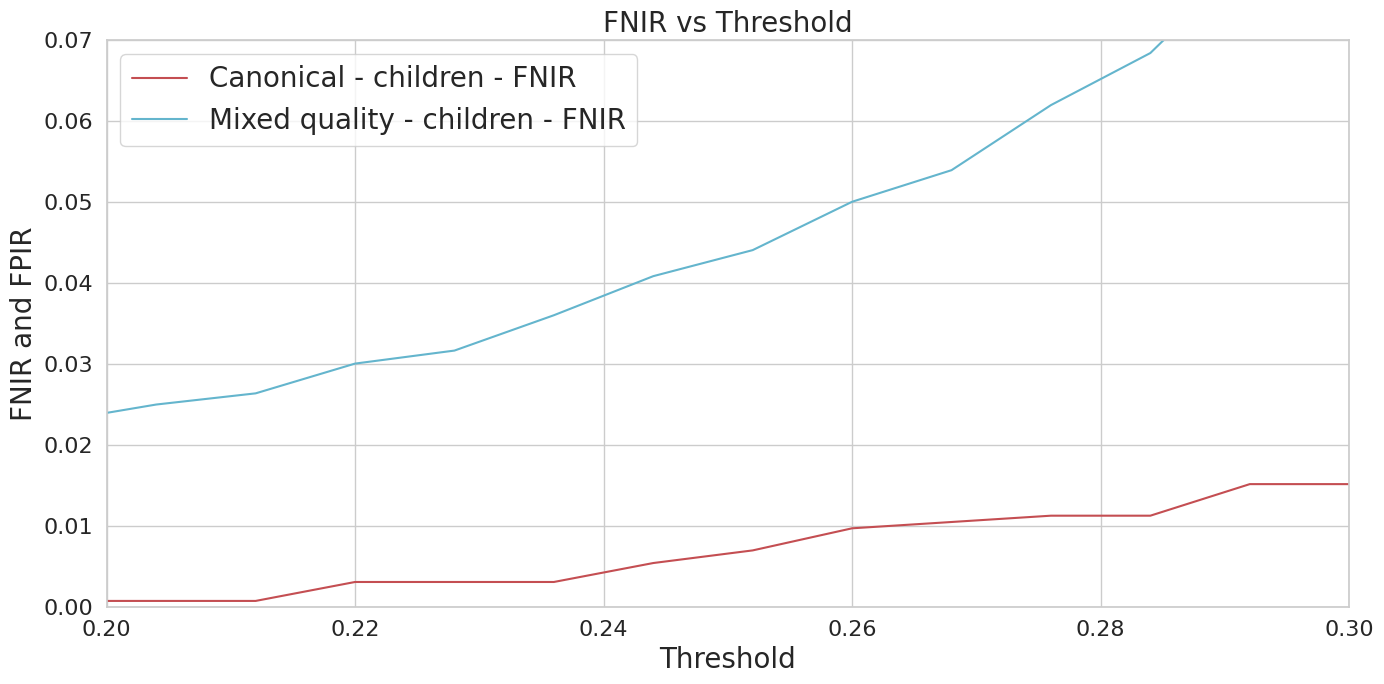

In [15]:

plot_threshold_metrics_ex_1_2_zoomed(df_all_threshold_x)

# Stats - 10 experiments 

In [3]:
random_states = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

df_all_results, sim_mat_dict_all_magface_ex1_2 = evaluate_metrics_ex_1_2(
    random_states, children_all, adults_all, image_names_c, image_names_a,
    sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data,
    balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE, remove_ones, 0.267
)

FPD result:  0.0
FND result:  0.31000508942479216
GARBE result, GARBE close to 1 means more unfair:  0.23250381706859413
done
FPD result:  0.0
FND result:  0.27385488762734267
GARBE result, GARBE close to 1 means more unfair:  0.205391165720507
done
FPD result:  0.011620157718356713
FND result:  0.2825499168053245
GARBE result, GARBE close to 1 means more unfair:  0.21481747703358253
done
FPD result:  0.0
FND result:  0.3198989061788637
GARBE result, GARBE close to 1 means more unfair:  0.23992417963414775
done
FPD result:  0.01226841868306724
FND result:  0.36464213140663804
GARBE result, GARBE close to 1 means more unfair:  0.2765487032257454
done
FPD result:  0.0
FND result:  0.30604934996020167
GARBE result, GARBE close to 1 means more unfair:  0.22953701247015124
done
FPD result:  0.010972435616799317
FND result:  0.26444464508410875
GARBE result, GARBE close to 1 means more unfair:  0.2010765927172814
done
FPD result:  0.020691882381108695
FND result:  0.32351041498466016
GARBE r

In [4]:
df_all_results.applymap(lambda x: f"{x:.3f}")

/tmp/ipykernel_22888/2398388374.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_all_results.applymap(lambda x: f"{x:.3f}")


,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE,Threshold
0,1.000,0.013,0.057,1.000,1.000,0.000,0.310,0.233,0.267
1,2.000,0.012,0.043,1.000,1.000,0.000,0.274,0.205,0.267
2,3.000,0.013,0.047,0.999,1.000,0.012,0.283,0.215,0.267
3,4.000,0.011,0.050,1.000,1.000,0.000,0.320,0.240,0.267
4,5.000,0.008,0.053,0.999,1.000,0.012,0.365,0.277,0.267
5,6.000,0.012,0.048,1.000,1.000,0.000,0.306,0.230,0.267
6,7.000,0.015,0.048,0.999,1.000,0.011,0.264,0.201,0.267
7,8.000,0.012,0.055,0.997,1.000,0.021,0.324,0.248,0.267
8,9.000,0.010,0.044,1.000,1.000,0.000,0.311,0.233,0.267
9,10.000,0.007,0.049,0.999,1.000,0.013,0.377,0.286,0.267


In [5]:
df_all_results.describe().applymap(lambda x: f"{x:.3f}")

/tmp/ipykernel_22888/1449581749.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_all_results.describe().applymap(lambda x: f"{x:.3f}")


,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE,Threshold
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,5.500,0.011,0.049,0.999,1.000,0.007,0.313,0.237,0.267
std,3.028,0.002,0.004,0.001,0.000,0.008,0.036,0.028,0.000
min,1.000,0.007,0.043,0.997,1.000,0.000,0.264,0.201,0.267
25%,3.250,0.010,0.048,0.999,1.000,0.000,0.288,0.218,0.267
50%,5.500,0.012,0.049,0.999,1.000,0.005,0.311,0.233,0.267
75%,7.750,0.013,0.052,1.000,1.000,0.012,0.323,0.246,0.267
max,10.000,0.015,0.057,1.000,1.000,0.021,0.377,0.286,0.267


# Gemmer simscores

In [6]:
df_all_results.to_csv('results_10_experiment_1_2_adaface.csv')

In [7]:
# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10
# List to hold all the arrays
sim_mat_c_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_2:
        sim_mat_c_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_2[key])

# Concatenate all arrays into one big array
sim_mat_c_enrolled_iterations_all = np.concatenate(sim_mat_c_enrolled_iterations)
sim_mat_c_enrolled_iterations_all = pd.DataFrame(sim_mat_c_enrolled_iterations_all)
sim_mat_c_enrolled_iterations_all.to_csv('sim_mat_c_enrolled_iterations_all_ada_1_2.csv', index=False)
# Print the big array
print(len(sim_mat_c_enrolled_iterations_all))



# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_2:
        sim_mat_a_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_2[key])

# Concatenate all arrays into one big array
sim_mat_a_enrolled_iterations_all = np.concatenate(sim_mat_a_enrolled_iterations)
sim_mat_a_enrolled_iterations_all = pd.DataFrame(sim_mat_a_enrolled_iterations_all)
sim_mat_a_enrolled_iterations_all.to_csv('sim_mat_a_enrolled_iterations_all_ada_1_2.csv', index=False)


# Print the big array
print(len(sim_mat_a_enrolled_iterations_all))

# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_c_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_2:
        sim_mat_c_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_2[key])

sim_mat_c_non_enrolled_iterations_all = np.concatenate(sim_mat_c_non_enrolled_iterations)
sim_mat_c_non_enrolled_iterations_all = pd.DataFrame(sim_mat_c_non_enrolled_iterations_all)
sim_mat_c_non_enrolled_iterations_all.to_csv('sim_mat_c_non_enrolled_iterations_all_ada_1_2.csv', index=False)
# Print the big array
print(len(sim_mat_c_non_enrolled_iterations_all))


# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_2:
        sim_mat_a_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_2[key])

sim_mat_a_non_enrolled_iterations_all = np.concatenate(sim_mat_a_non_enrolled_iterations)
sim_mat_a_non_enrolled_iterations_all = pd.DataFrame(sim_mat_a_non_enrolled_iterations_all)
sim_mat_a_non_enrolled_iterations_all.to_csv('sim_mat_a_non_enrolled_iterations_all_ada_1_2.csv', index=False)

# Print the big array
print(len(sim_mat_a_non_enrolled_iterations_all))


89426
121256
14218887
32751054


# Load sim scores

In [8]:

# Loading pre-saved stuff
sim_mat_c_enrolled_iterations_all = (pd.read_csv('sim_mat_c_enrolled_iterations_all_ada_1_2.csv')).values.flatten()
sim_mat_a_enrolled_iterations_all = (pd.read_csv('sim_mat_a_enrolled_iterations_all_ada_1_2.csv')).values.flatten()
sim_mat_c_non_enrolled_iterations_all = (pd.read_csv('sim_mat_c_non_enrolled_iterations_all_ada_1_2.csv')).values.flatten()
sim_mat_a_non_enrolled_iterations_all = (pd.read_csv('sim_mat_a_non_enrolled_iterations_all_ada_1_2.csv')).values.flatten()


# From DET utils - check import

In [9]:
from scipy.stats import describe, gaussian_kde
import math

def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

In [10]:
mated_scores1 = sim_mat_a_enrolled_iterations_all
nonmated_scores1 = sim_mat_a_non_enrolled_iterations_all
scores_type1 = "similarity"
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df)

,Statistic,Mated,Non-mated
0,Observations,121256.000000,3.275105e+07
1,Minimum,0.030712,-3.562537e-01
2,Maximum,0.998967,9.998881e-01
3,Mean,0.583003,1.374232e-01
4,St. Dev.,0.151178,1.173985e-01
5,Skewness,-0.209160,3.989444e-01
6,Ex. Kurtosis,-0.022230,2.163939e-01


In [11]:
mated_scores2 = sim_mat_c_enrolled_iterations_all

nonmated_scores2 = sim_mat_c_non_enrolled_iterations_all
scores_type2 = "similarity"
stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
display(stats_system2_df)

,Statistic,Mated,Non-mated
0,Observations,89426.000000,1.421889e+07
1,Minimum,0.030712,-3.182690e-01
2,Maximum,0.998967,9.998881e-01
3,Mean,0.610715,1.430892e-01
4,St. Dev.,0.144527,1.198183e-01
5,Skewness,-0.281584,4.261789e-01
6,Ex. Kurtosis,0.050684,3.556785e-01


In [12]:
mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

In [13]:

import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(mated_scores, nonmated_scores, normalise=True, savename=None, title="Histogram"):
    def normalise_scores(distribution):
        return np.ones_like(distribution) / len(distribution)

    mated_mean = np.mean(mated_scores)

    plt.figure(figsize=(10, 6))  # Replace 'figure_size' with a specific size if not defined

    if normalise:
        plt.hist(mated_scores, bins=50, weights=normalise_scores(mated_scores), color='green', alpha=0.5, label='Mated Scores')  # Replace 'mated_label' with 'Mated Scores'
        plt.hist(nonmated_scores, bins=30, weights=normalise_scores(nonmated_scores), color='red', alpha=0.5, label='Non-mated Scores')  # Replace 'nonmated_label' with 'Non-mated Scores'
        ylabel = "Probability Density"
    else:
        plt.hist(mated_scores, bins=50, color='green', alpha=0.5, label='Mated Scores')
        plt.hist(nonmated_scores, bins=30, color='red', alpha=0.5, label='Non-mated Scores')
        ylabel = "Count"

    plt.axvline(mated_mean, color='darkgreen', linestyle='--', linewidth=2, label=f'Mated Mean: {mated_mean:.2f}')

    plt.xlabel("Comparison Score", size=12)  # Replace 'label_fontsize' with 12 or any preferred size
    plt.ylabel(ylabel, size=12)  # Replace 'label_fontsize' with 12 or any preferred size
    plt.title(title, size=14)  # Title added here
    plt.grid(True)
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)  # Adjust legend parameters as needed

    if savename is not None:
        plt.savefig(savename, bbox_inches="tight")
        plt.cla()
        plt.clf()
        plt.close()
    else:
        plt.show()


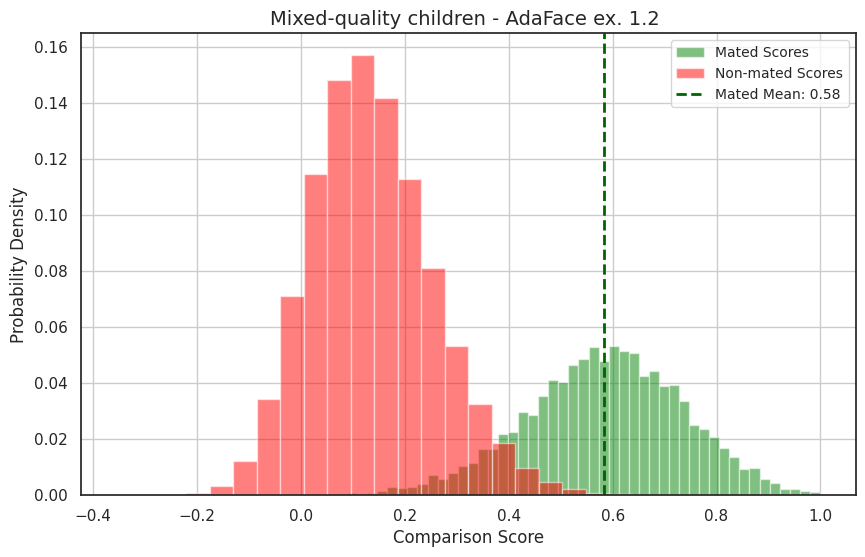

In [14]:

plot_histogram(mated_scores1, nonmated_scores1, normalise=True, title = 'Mixed-quality children - AdaFace ex. 1.2 ')


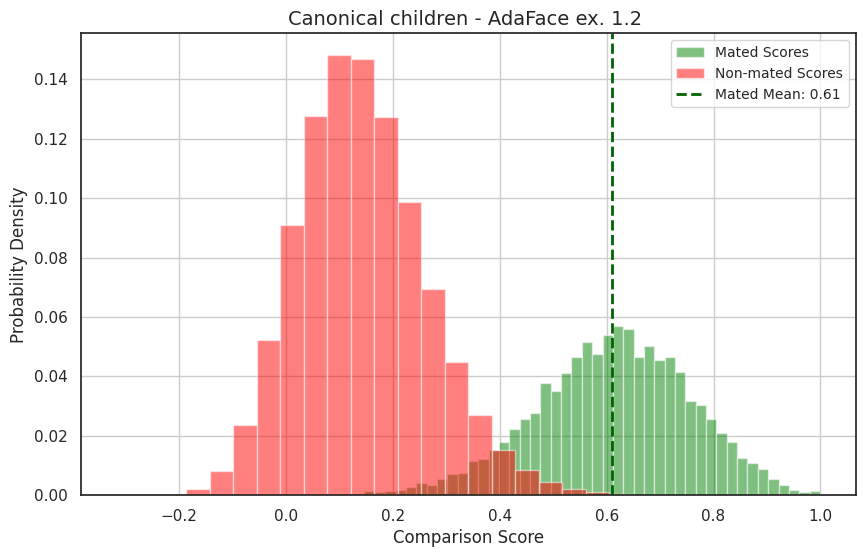

In [15]:
plot_histogram(mated_scores2, nonmated_scores2, normalise=True,title = 'Canonical children - AdaFace ex. 1.2 ')


# DET CURVES

In [16]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores1)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores1)

In [17]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' mixed =", round(d_prime_system1, round_digits))

d_prime_system2 = d_prime(mated_scores2, nonmated_scores2)
print("d' canonical =", round(d_prime_system2, round_digits))


d' mixed = 3.29216
d' canonical = 3.52265


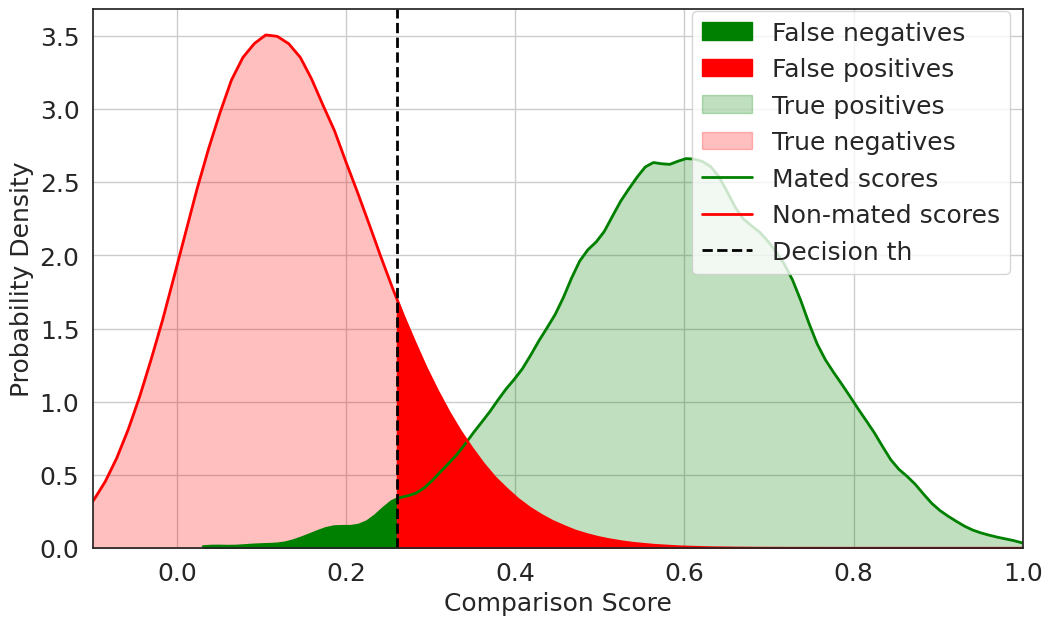

In [18]:
threshold1 = 0.26
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1)

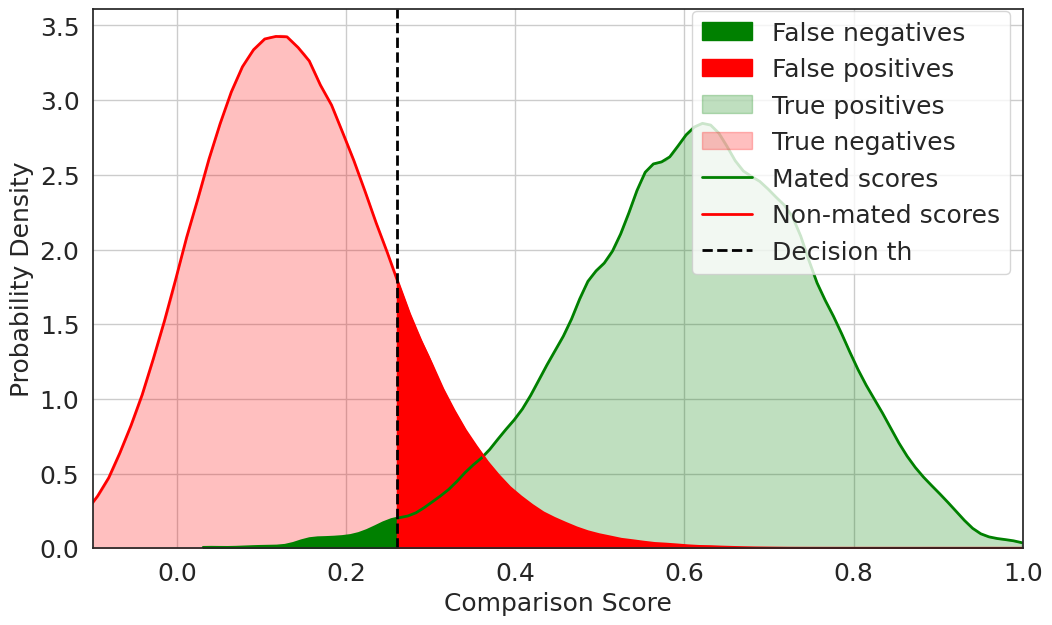

In [19]:
threshold2 = 0.26
kde_with_threshold(mated_scores2, nonmated_scores2, scores_type2, threshold2)

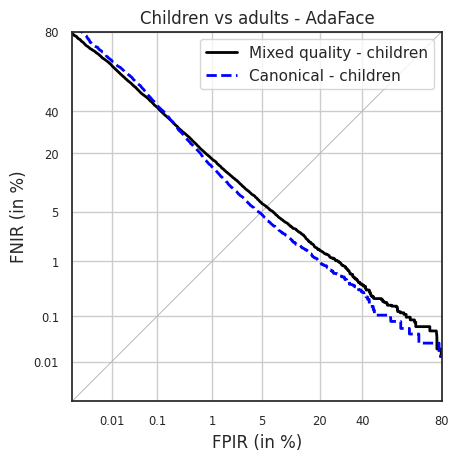

In [20]:
system_name1 = 'Mixed quality - children'
system_name2 = 'Canonical - children'

det = DET(biometric_evaluation_type='identification', abbreviate_axes=True, plot_eer_line=True, plot_title="Children vs adults - AdaFace")
det.x_limits = np.array([1e-5, .8])
det.y_limits = np.array([1e-5, .8])
det.x_ticks = np.array([1e-4, 1e-3, 1e-2, 5e-2, 20e-2, 40e-2, 80e-2])
det.x_ticklabels = np.array(['0.01','0.1', '1', '5', '20', '40', '80'])
det.y_ticks = np.array([1e-4, 1e-3, 1e-2, 5e-2, 20e-2, 40e-2, 80e-2])
det.y_ticklabels = np.array(['0.01','0.1', '1', '5', '20', '40', '80'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores2, scores_type2), non=adjust_scores_for_DET(nonmated_scores2, scores_type2), label=system_name2)
det.legend_on(loc="upper right")
det.show()